In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from tqdm import tqdm
import itertools

import sys
sys.path.append('../')
from tracker import loadAntData, pltsaveall, discretizeTrajectory

# Update source files before running each cell
%load_ext autoreload
%autoreload 2

From tracker/_init__.py:
SLEAP not detected; make sure to install SLEAP if intending to use postprocessing notebook. Otherwise, ignore this message.


In [2]:
dataFile = '/home/jack/Workspaces/data/ant_tracking/ant_dataset_1_2025-09-20.h5'

minimumLength = 5 # seconds
smoothingWindow = 10 # frames
maximumTimeSkip = 10 # frames

excludeOutliers = True
excludeShortSegments = True
excludeObjects = True

padding = None # mm
inversePadding = 10 # mm

dataArr, timeArr, metadataArr = loadAntData(dataFile, minimumLength, smoothingWindow, maximumTimeSkip,
                                            excludeOutliers, excludeShortSegments, excludeObjects,
                                            padding, inversePadding, debug=True)

Keeping only trajectories near walls: 100%|██| 494/494 [00:00<00:00, 977.39it/s]


Loaded 2524 segments!


As is emphasized in many other parts of this project, discretizing a continuous trajectory is a very subjective process, so you need to be very careful in choosing your parameters. As such, here we survey a range of parameters, principally the colinearity threshold (`c`) and the velocity threshold (`velocityThreshold`).

In [3]:
# Convert to discrete steps
# Given as a colinearity value, between [0, 1]
cArr = [0.3, 0.60]
# The minimum velocity that we use to identify waiting
# periods, in mm/s
velocityThresholdArr = [5] # mm/s
# These two arrays give values of each individual parameter
# so the total number of samples is the product of their lengths.

# These parameters are not as important as the ones above, but still
# should be given adequate thought
minDistancePerRun = 1 # mm
minStepsPerRun = 5 # frames

discreteDataArr = []
discreteStepSizeArr = []
waitTimeArr = []
runTimeArr = []

# Since we have two parameters, we should generate
# each pair of parameters.
allParams = np.array(list(itertools.product(cArr, velocityThresholdArr)))

# Replace the above lists
cArr = allParams.T[0]
velocityThresholdArr = allParams.T[1]

for i in range(len(cArr)):
    discreteDataArr.append([])
    discreteStepSizeArr.append([])
    waitTimeArr.append([])
    runTimeArr.append([])

    for j in tqdm(range(len(dataArr))):
        discreteTraj, waitingTimes, runTimes = discretizeTrajectory(dataArr[j],
                                                                    c=cArr[i],
                                                                    velocityThreshold=velocityThresholdArr[i],
                                                                    dt=1/metadataArr[j]["fps"],
                                                                    minSteps=minStepsPerRun,
                                                                    minDistancePerRun=minDistancePerRun,
                                                                    debug=False)
        discreteDataArr[-1].append(discreteTraj)
        
        discreteStepSizeArr[-1].append(np.sqrt(np.sum((discreteTraj[1:] - discreteTraj[:-1])**2, axis=-1)))
        waitTimeArr[-1].append(waitingTimes)
        runTimeArr[-1].append(runTimes)

  0%|                                                  | 0/2524 [00:00<?, ?it/s]/home/jack/Workspaces/python/ant_tracking/notebooks/../tracker/discretize.py:123: RuntimeWarning: invalid value encountered in divide
  absoluteAngleArr = np.arctan2(*(originalStepDirectionArr.T / np.sqrt(np.sum(originalStepDirectionArr**2, axis=-1))))
100%|███████████████████████████████████████| 2524/2524 [01:04<00:00, 39.11it/s]


## Turn angle distribution

In [4]:
def computeAngles(trajectory, dt=1, minVelocityThreshold=1):
    # Compute the velocity for the trajectory
    velocityArr = (trajectory[1:] - trajectory[:-1]) / dt
    velocityMagnitudes = np.sqrt(np.sum(velocityArr**2, axis=-1))
    # Make unit vectors
    velocityArr[:,0] = velocityArr[:,0] / velocityMagnitudes
    velocityArr[:,1] = velocityArr[:,1] / velocityMagnitudes

    # Now take angle differences for the steps
    # The clip is to avoid numerical errors
    angleDifferenceArr = np.array([np.arccos(np.clip(np.dot(velocityArr[i], velocityArr[i+1]), -1., 1.)) for i in range(len(velocityArr)-1)])

    # To compute the sign of the angle, we need
    # to use the cross product
    signArr = np.array([np.sign(np.cross(velocityArr[i], velocityArr[i+1])) for i in range(len(velocityArr)-1)])
    angleDifferenceArr = angleDifferenceArr * signArr

    # Threshold, since tiny velocities could just be jitter
    angleDifferenceArr = angleDifferenceArr[velocityMagnitudes[1:] + velocityMagnitudes[:-1] > minVelocityThreshold]
    angleDifferenceArr[angleDifferenceArr == np.nan] = 0
    
    return angleDifferenceArr[~np.isnan(angleDifferenceArr)]

In [5]:
# Convert to discrete steps
fps = metadataArr[0]["fps"]
velocityThreshold = 10 # mm/s

angleArr = []

for i in range(len(cArr)):
    angleArr.append([])
    
    for j in tqdm(range(len(dataArr))):
        discreteData = discreteDataArr[i][j] 

        angles = computeAngles(discreteData,
                               dt=1/fps,
                               minVelocityThreshold=velocityThresholdArr[i])

        angleArr[-1].append(angles)

100%|█████████████████████████████████████| 2524/2524 [00:00<00:00, 5656.21it/s]


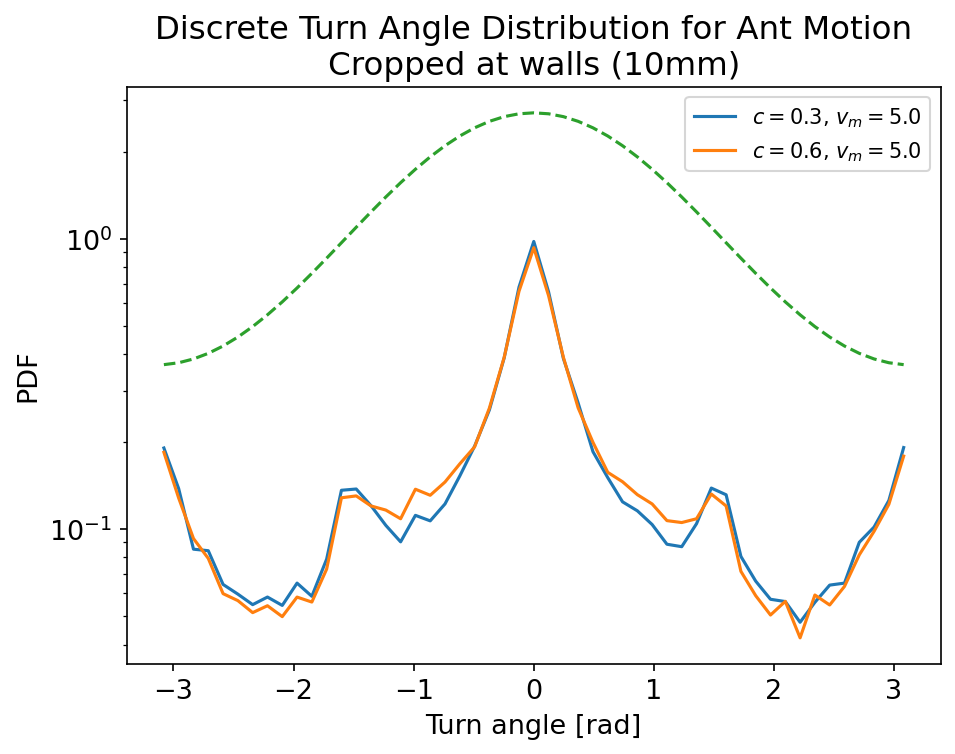

In [6]:
numBins = 51

bins = np.linspace(-np.pi, np.pi, numBins+1)
#bins = np.logspace(-1, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(cArr)):
    # Flatten each trajectory so we can take a histogram
    # of every combined segment
    angles = np.array([a for aa in angleArr[i] for a in aa])
    #angles[angles == 0] = np.nan
    
    meanDist, meanBins = np.histogram(angles, bins=bins, density=True)
    plt.plot(binArr, meanDist, '-', label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$')#   ($\\theta_c = {np.arccos(angleThresholdArr[i])*180 / np.pi:.3}\\degree$)')

k = 1
plt.plot(binArr, 1/k * np.exp(k * np.cos(binArr)), '--')
plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Turn angle [rad]')
plt.legend(fontsize=10)
#plt.title('Discrete Turn Angle Distribution for Ant Motion\nUncropped')
plt.title('Discrete Turn Angle Distribution for Ant Motion\nCropped at walls (10mm)')
plt.gcf().set_size_inches((7,5))
#pltsaveall('08_DiscreteTurnAngle_Cropped')
plt.show()

## Run length distribution

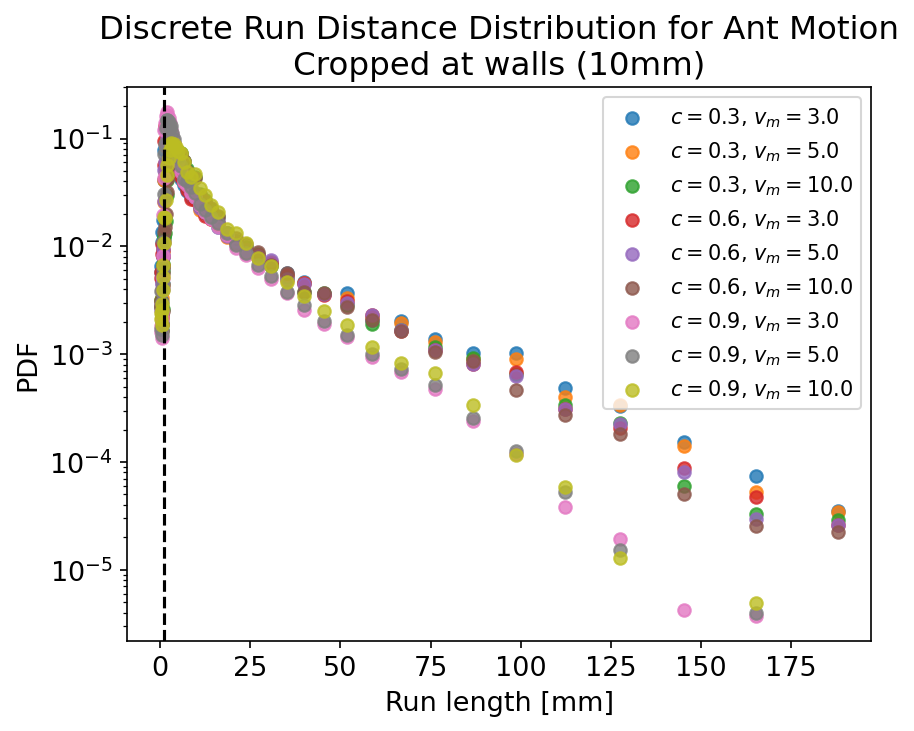

In [131]:
numBins = 50
maxDistance = 200

#bins = np.linspace(0, maxDistance, numBins+1)
bins = np.logspace(-0.5, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(discreteStepSizeArr)):
    steps = [s for ds in discreteStepSizeArr[i] for s in ds]
    meanDist, meanBins = np.histogram(steps, bins=bins, density=True)

    plt.scatter(binArr, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.8)
    
    # np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

plt.axvline(minDistancePerRun, linestyle='--', c='black')

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run length [mm]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Distance Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Distance Distribution for Ant Motion\nCropped at walls (10mm)')
#pltsaveall('08_DiscreteRunDistance_Cropped')
plt.show()

## Run time distribution

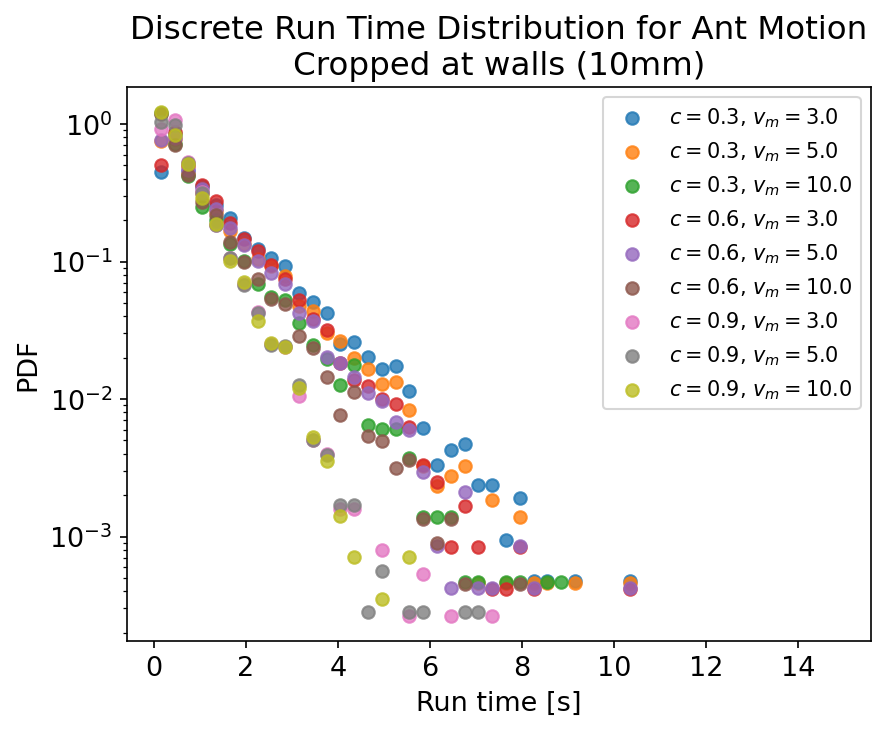

In [111]:
numBins = 50
maxTime = 15

bins = np.linspace(0, maxTime, numBins+1)
#bins = np.logspace(0, np.log10(maxTime), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(runTimeArr)):
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])
    meanDist, meanBins = np.histogram(runTimes, bins=bins, density=True)

    plt.scatter(binArr, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.8)
    
#    np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Run time [s]')
plt.legend(fontsize=10)
#plt.title('Discrete Run Time Distribution for Ant Motion\nUncropped')
plt.title('Discrete Run Time Distribution for Ant Motion\nCropped at walls (10mm)')
pltsaveall('08_DiscreteRunTime_Cropped')
plt.show()

## Wait time distribution

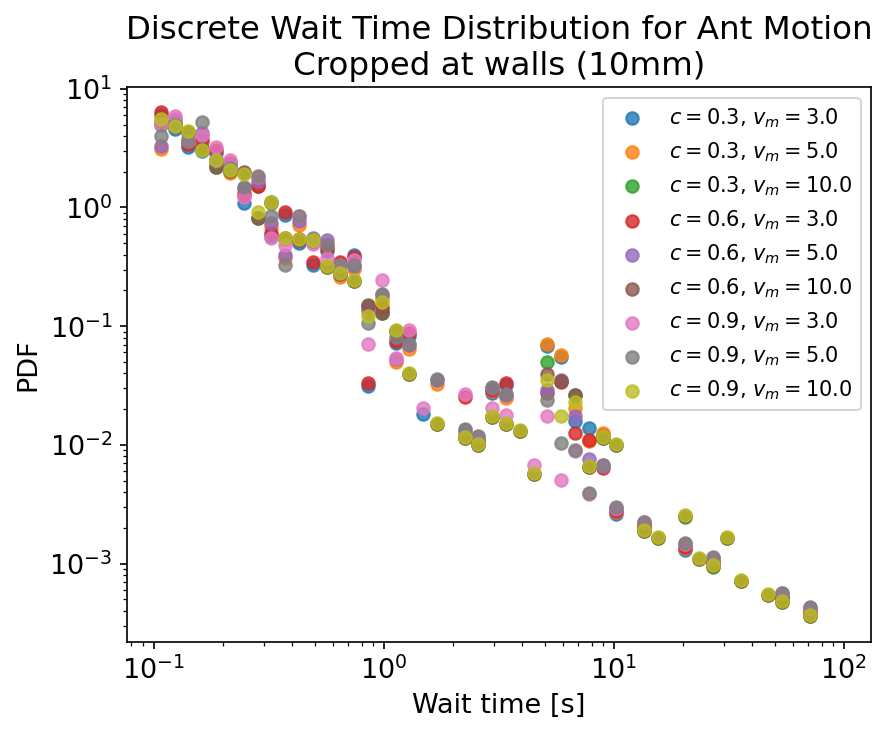

In [112]:
numBins = 50
maxTime = 100

#bins = np.linspace(0, maxTime, numBins+1)
bins = np.logspace(-1, np.log10(maxTime), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(waitTimeArr)):
    waitTimes = np.array([t for wt in waitTimeArr[i] for t in wt])
    meanDist, meanBins = np.histogram(waitTimes / metadataArr[0]["fps"], bins=bins, density=True)
    plt.scatter(binArr, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.8)
    
#    np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

plt.yscale('log')
plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Wait time [s]')
plt.legend(fontsize=10)
#plt.title('Discrete Wait Time Distribution for Ant Motion\nUncropped')
plt.title('Discrete Wait Time Distribution for Ant Motion\nCropped at walls (10mm)')
pltsaveall('08_DiscreteWaitTime_Cropped')
plt.show()

## Average run speed

12.045284889857387
14.280852649294328
22.9484360549309
12.484117311133042
14.574893311143837
22.990303301242392
14.105551426299153
15.520761704664995
22.8310027459179


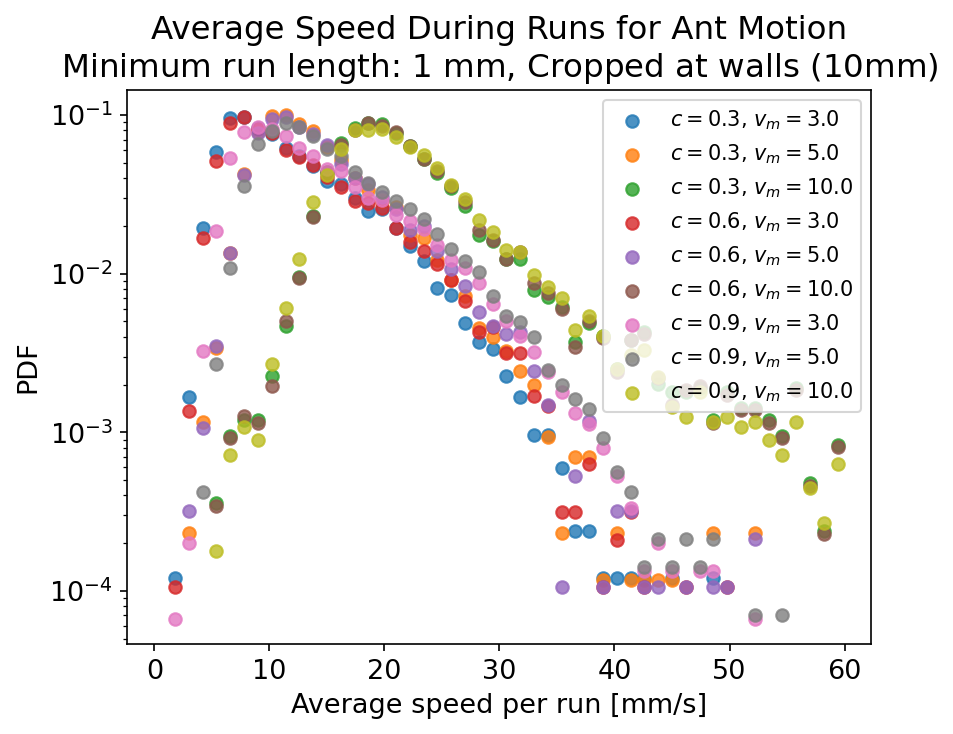

In [113]:
numBins = 50
maxVelocity = 60
minRunLength = minDistancePerRun

bins = np.linspace(0, maxVelocity, numBins+1)
#bins = np.logspace(-1, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

for i in range(len(discreteDataArr)):
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where((runLengths > minRunLength) & (runTimes > 0))[0]
    avgVelocity = runLengths[goodIndices] / runTimes[goodIndices]

    print(np.nanmean(avgVelocity))
    meanDist, meanBins = np.histogram(avgVelocity, bins=bins, density=True)

    plt.scatter(binArr, meanDist, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', alpha=0.8)

plt.yscale('log')
#plt.xscale('log')
plt.ylabel('PDF')
plt.xlabel('Average speed per run [mm/s]')
plt.legend(fontsize=10)
#plt.title(f'Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Uncropped')
plt.title(f'Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
pltsaveall('08_AverageSpeedPerRun_Cropped')
plt.show()

/tmp/ipykernel_71578/3904931303.py:11: RuntimeWarning: divide by zero encountered in divide
  avgVelocity = runLengths / runTimes


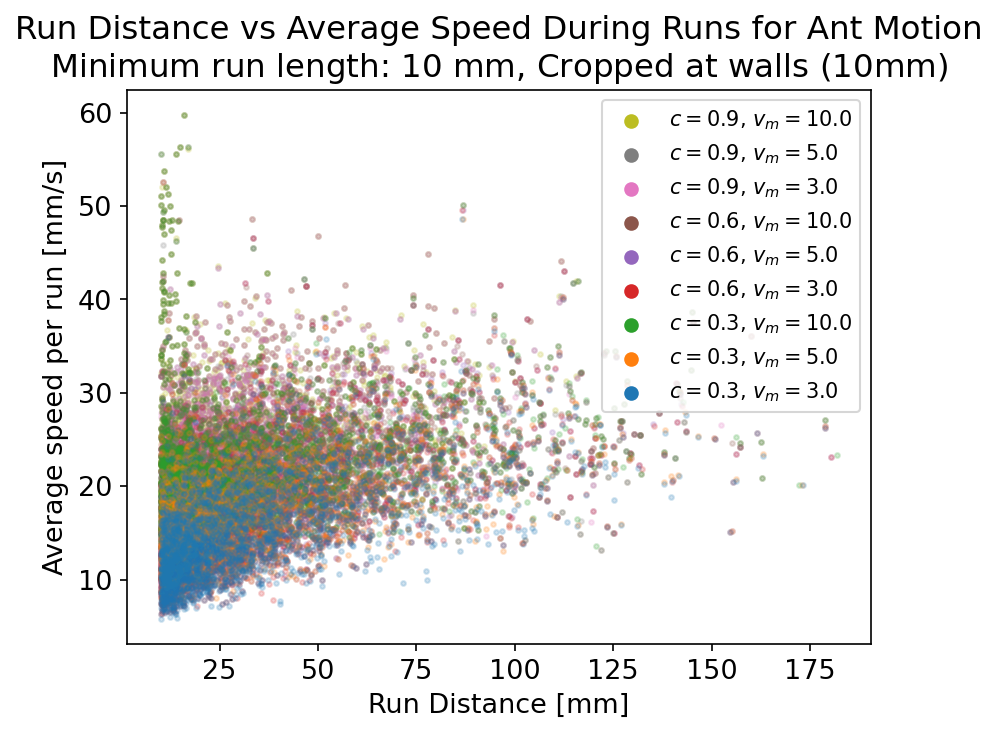

In [115]:
minRunLength = 10
maxRunLength = 200
maxSpeed = 60
colors = list(mpl.colors.TABLEAU_COLORS)

for i in range(len(runTimeArr))[::-1]:
    runLengths = np.array([l for rl in discreteStepSizeArr[i] for l in rl])
    runTimes = np.array([t for rt in runTimeArr[i] for t in rt])

    goodIndices = np.where(runLengths > minRunLength)[0]
    avgVelocity = runLengths / runTimes
    
    runLengths = runLengths[goodIndices]
    avgVelocity = avgVelocity[goodIndices]
    
    goodIndices = np.where(avgVelocity <= maxSpeed)[0]

    plt.scatter(runLengths[goodIndices], avgVelocity[goodIndices], alpha=0.2, s=5, c=colors[i])
    # To make the legend look nicer
    plt.scatter(None, None, label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i])
    
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('Run Distance [mm]')
plt.ylabel('Average speed per run [mm/s]')
#plt.title(f'Skip factor: {skipFactor}')
plt.legend(fontsize=10)
#plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Uncropped')
plt.title(f'Run Distance vs Average Speed During Runs for Ant Motion\nMinimum run length: ${minRunLength}$ mm, Cropped at walls (10mm)')
pltsaveall('08_RunDistanceVsSpeed_Cropped')
plt.show()

## Autocorrelation of run length

In [116]:
# Compute the autocorrelation of the run length, to see long runs
# tend to happen sequentially

# Compute the autocorrelation
def autocorr(x, maxLag=20, dt=1):
    # Start as ones since the first entry should be 1
    autocorrArr = np.zeros(int(maxLag // dt))
    tArr = np.linspace(0, maxLag, len(autocorrArr))
    
    autocorrArr[0] = np.mean(x**2)
    for i in range(1, len(autocorrArr)):
        autocorrArr[i] = np.mean(x[:-i] * x[i:])
        
    return tArr, autocorrArr

  0%|                                                  | 0/1091 [00:00<?, ?it/s]/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████| 1091/1091 [00:00<00:00, 4216.54it/s]


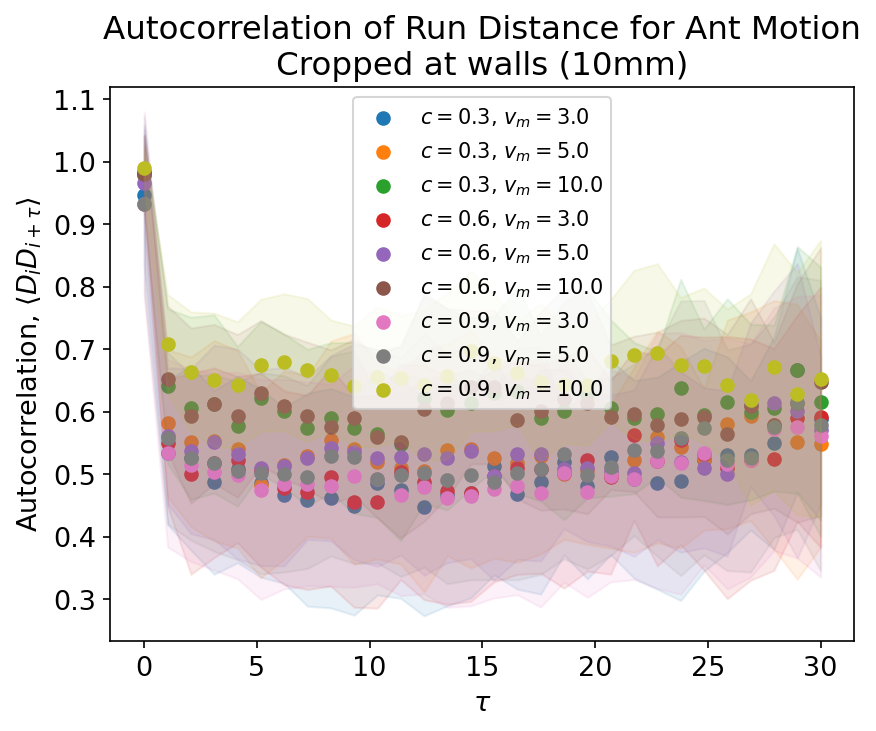

In [117]:
numBins = 50
maxDistance = 200

#bins = np.linspace(0, maxDistance, numBins+1)
bins = np.logspace(-0.5, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

colors = list(mpl.colors.TABLEAU_COLORS)

for i in range(len(discreteStepSizeArr)):
    corrArr = []
    for ds in tqdm(discreteStepSizeArr[i]):
        tArr, corr = autocorr(ds, 30)
        corr[corr == 0] = np.nan
        corr = corr / np.max(corr)
        corrArr.append(corr)

    corrArr = np.array(corrArr)

    plt.scatter(tArr, np.nanmean(corrArr, axis=0), label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i])
    err = np.nanstd(corrArr, axis=0)
    plt.fill_between(tArr, np.nanmean(corrArr, axis=0) - err, np.nanmean(corrArr, axis=0) + err, alpha=0.1, color=colors[i])
    # np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

#plt.axvline(minDistancePerRun, linestyle='--', c='black')

#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Autocorrelation, $\\langle D_i D_{i + \\tau} \\rangle$')
plt.xlabel('$\\tau$')
plt.legend(fontsize=10)
#plt.title('Autocorrelation of Run Distance for Ant Motion\nUncropped')
plt.title('Autocorrelation of Run Distance for Ant Motion\nCropped at walls (10mm)')
pltsaveall('08_AutocorrelationRunDistance_Cropped')
plt.show()

## Autocorrelation of wait times

In [91]:
# Compute the autocorrelation of the run length, to see long runs
# tend to happen sequentially

# Compute the autocorrelation
def autocorr(x, maxLag=20, dt=1):
    # Start as ones since the first entry should be 1
    autocorrArr = np.zeros(int(maxLag // dt))
    tArr = np.linspace(0, maxLag, len(autocorrArr))
    
    autocorrArr[0] = np.mean(x**2)
    for i in range(1, len(autocorrArr)):
        autocorrArr[i] = np.mean(x[:-i] * x[i:])
        
    return tArr, autocorrArr

  0%|                                                  | 0/1091 [00:00<?, ?it/s]/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
100%|█████████████████████████████████████| 1091/1091 [00:00<00:00, 4385.95it/s]


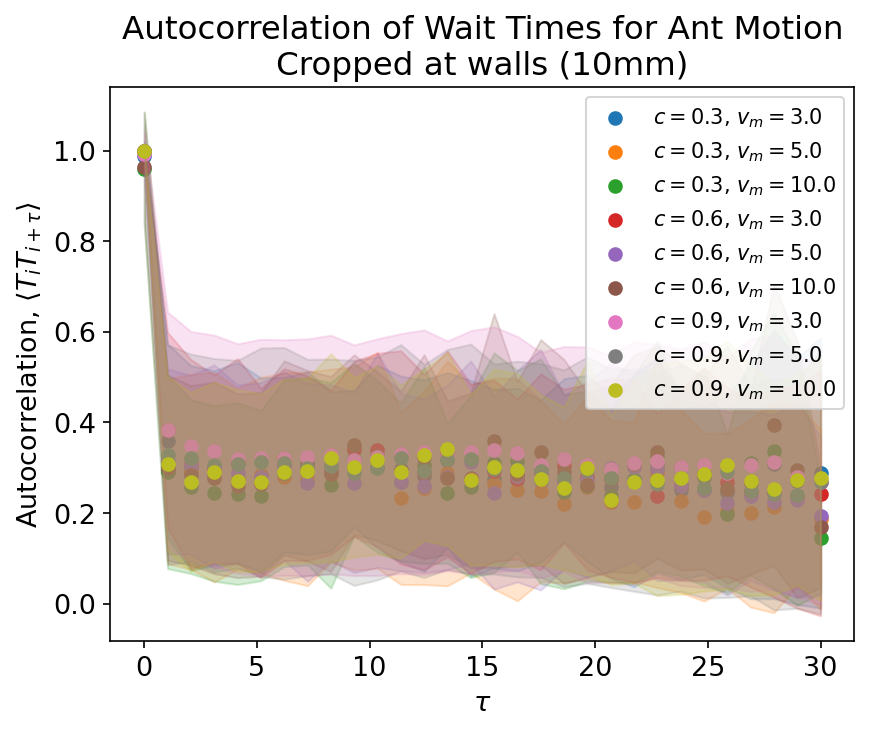

In [118]:
numBins = 50
maxDistance = 200

#bins = np.linspace(0, maxDistance, numBins+1)
bins = np.logspace(-0.5, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2

colors = list(mpl.colors.TABLEAU_COLORS)

for i in range(len(discreteStepSizeArr)):
    corrArr = []
    for wt in tqdm(waitTimeArr[i]):
        tArr, corr = autocorr(wt, 30)
        corr[corr == 0] = np.nan
        corr = corr / np.max(corr)
        corrArr.append(corr)

    corrArr = np.array(corrArr)

    plt.scatter(tArr, np.nanmean(corrArr, axis=0), label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i])
    err = np.nanstd(corrArr, axis=0)
    plt.fill_between(tArr, np.nanmean(corrArr, axis=0) - err, np.nanmean(corrArr, axis=0) + err, alpha=0.2, color=colors[i])
    # np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

#plt.axvline(minDistancePerRun, linestyle='--', c='black')

#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Autocorrelation, $\\langle T_i T_{i + \\tau} \\rangle$')
plt.xlabel('$\\tau$')
plt.legend(fontsize=10)
#plt.title('Autocorrelation of Wait Times for Ant Motion\nUncropped')
plt.title('Autocorrelation of Wait Times for Ant Motion\nCropped at walls (10mm)')
pltsaveall('08_AutocorrelationWaitTimes_Cropped')
plt.show()

## Autocorrelation of run velocity

In [119]:
# Compute the autocorrelation of the run length, to see long runs
# tend to happen sequentially

# Compute the autocorrelation
def autocorr(x, maxLag=20, dt=1):
    # Start as ones since the first entry should be 1
    autocorrArr = np.zeros(int(maxLag // dt))
    tArr = np.linspace(0, maxLag, len(autocorrArr))
    
    autocorrArr[0] = np.mean(x**2)
    for i in range(1, len(autocorrArr)):
        autocorrArr[i] = np.mean(x[:-i] * x[i:])
        
    return tArr, autocorrArr

  0%|                                                  | 0/1091 [00:00<?, ?it/s]/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/jack/miniconda3/envs/311/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_71578/3715383443.py:13: RuntimeWarning: divide by zero encountered in divide
  avgVelocity = discreteStepSizeArr[i][j][goodIndices] / runTimeArr[i][j][goodIndices]
100%|████████████████████████████████████| 1091/1091 [00:00<00:00, 11803.30it/s]


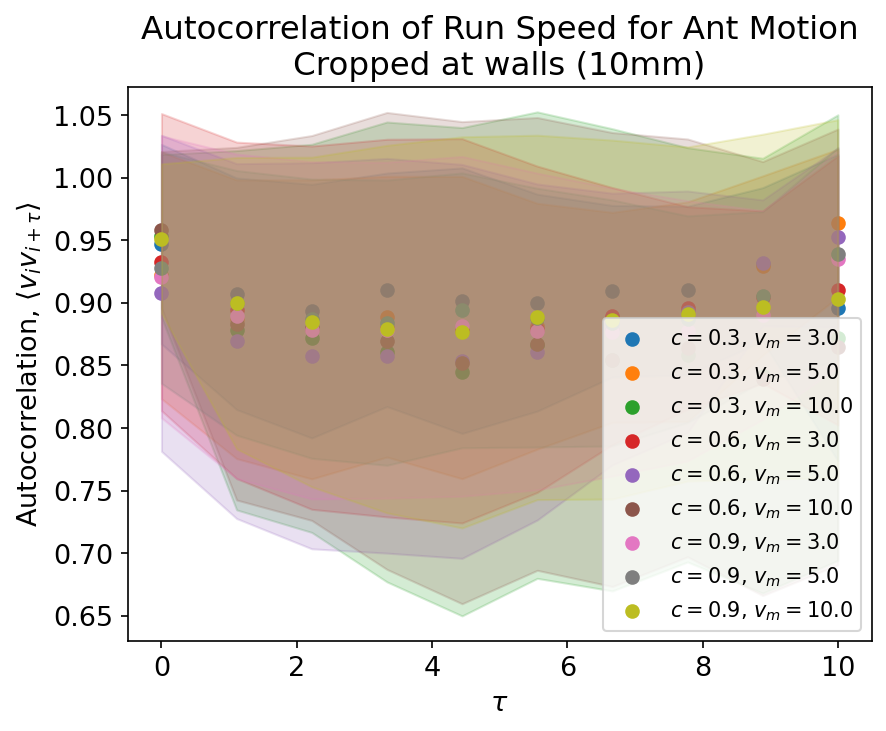

In [128]:
numBins = 50
maxDistance = 200

#bins = np.linspace(0, maxDistance, numBins+1)
bins = np.logspace(-0.5, np.log10(maxDistance), numBins+1)
binArr = (bins[1:] + bins[:-1])/2
colors = list(mpl.colors.TABLEAU_COLORS)

for i in range(len(discreteStepSizeArr)):
    corrArr = []
    for j in tqdm(range(len(runTimeArr[i]))):    
        goodIndices = np.where(discreteStepSizeArr[i][j] > minRunLength)[0]
        avgVelocity = discreteStepSizeArr[i][j][goodIndices] / runTimeArr[i][j][goodIndices]

        tArr, corr = autocorr(avgVelocity, 10)
        corr[corr == 0] = np.nan
        corr = corr / np.max(corr)
        corrArr.append(corr)

#    print(corrArr)
    corrArr = np.array(corrArr)

    plt.scatter(tArr, np.nanmean(corrArr, axis=0), label=f'$c = {cArr[i]}$, $v_m = {velocityThresholdArr[i]}$', c=colors[i])
    err = np.nanstd(corrArr, axis=0)
    plt.fill_between(tArr, np.nanmean(corrArr, axis=0) - err, np.nanmean(corrArr, axis=0) + err, alpha=0.2, color=colors[i])
    # np.savetxt(f'step_dist_{angleThresholdArr[i]}.csv', meanDist)

#plt.axvline(minDistancePerRun, linestyle='--', c='black')

#plt.yscale('log')
#plt.xscale('log')
plt.ylabel('Autocorrelation, $\\langle v_i v_{i + \\tau} \\rangle$')
plt.xlabel('$\\tau$')
plt.legend(fontsize=10)
#plt.title('Autocorrelation of Run Speed for Ant Motion\nUncropped')
plt.title('Autocorrelation of Run Speed for Ant Motion\nCropped at walls (10mm)')
pltsaveall('08_AutocorrelationRunSpeed_Cropped')
plt.show()